In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow-addons

In [ ]:
!pip install matplotlib

In [ ]:
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow import keras


# !pip uninstall tensorflow-addons -y
# !pip install tensorflow-addons==0.21.0

In [ ]:
from tensorflow.keras import layers

In [ ]:
import tensorflow_addons as tfa
import matplotlib.pyplot as plt


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
num_classes = 10
input_shape = (32,32,3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 5s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5
image_size = 72
patch_size = 6
num_patches = (image_size//patch_size)**2
num_heads = 4
projection_dim = 64
transformer_units = [projection_dim*2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048,1024]

In [ ]:
data_augmentation = keras.Sequential([layers.Normalization(),
layers.Resizing(image_size,image_size),
layers.RandomFlip("horizontal"),
layers.RandomRotation(factor = 0.2),
layers.RandomZoom(height_factor=0.2,width_factor=0.2)],
name = "data_augmentation"
)

data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x,hidden_units,dropout_rate):
  for units in hidden_units:
    units = tf.cast(units, tf.int32)
    x = layers.Dense(units ,activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [ ]:
class Patches(layers.Layer):
  def __init__(self,patch_size):
    super(Patches,self).__init__()
    self.patch_size = patch_size

  def call(self,images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images = images,
                                       sizes = [1,self.patch_size,self.patch_size,1],
                                       strides = [1,self.patch_size,self.patch_size,1],
                                       rates = [1,1,1,1],
                                       padding = "VALID")
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size,-1,patch_dims])
    return patches



Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


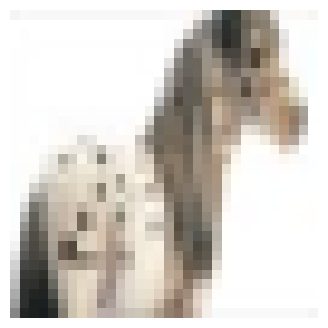

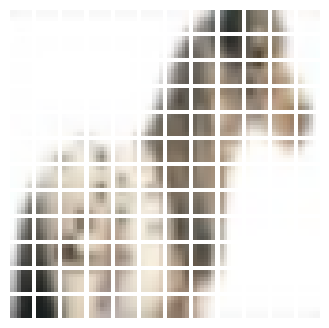

In [ ]:
plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]),(image_size,image_size))
patches = Patches(patch_size)(resized_image)

print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))

for i,patch in enumerate(patches[0]):
  ax = plt.subplot(n,n,i+1)
  patch_img = tf.reshape(patch,(patch_size,patch_size,3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
  def __init__(self,num_patches,projection_dim):
    super(PatchEncoder,self).__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units = projection_dim)
    self.position_embedding = layers.Embedding(input_dim = num_patches,output_dim = projection_dim)

  def call(self,patch):
    positions = tf.range(start = 0,limit = self.num_patches,delta = 1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded


In [ ]:
def create_vit_classifier():
  inputs = layers.Input(shape = input_shape)
  augmented = data_augmentation(inputs)
  patches = Patches(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches,projection_dim)(patches)

  for _ in range(transformer_layers):
    x1 = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    attention_output = layers.MultiHeadAttention(num_heads = num_heads,key_dim = projection_dim,dropout = 0.1)(x1,x1)
    x2 = layers.Add()([attention_output, x1])
    x3 = layers.LayerNormalization(epsilon = 1e-6)(x2)
    x3 = mlp(x3,hidden_units = [projection_dim],dropout_rate = 0.1)
    encoded_patches = layers.Add()([x3, x2])

  representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  print(representation.shape)
  # representation = layers.Lambda(lambda x: x)(representation)
  # print(representation.shape)


  features = mlp(representation,hidden_units = [int(representation.shape[-1])],dropout_rate = 0.5)
  logits = layers.Dense(num_classes)(features)

  model = keras.Model(inputs = inputs,outputs = logits)
  return model

In [ ]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate,weight_decay = weight_decay)
  model.compile(optimizer = optimizer,loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),metrics = ["accuracy"])
  checkpoint_filepath = "/tmp/checkpoint"
  checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,monitor = "val_accuracy",save_best_only = True)
  history = model.fit(
      x = x_train,
      y = y_train,batch_size = batch_size,
      epochs = num_epochs,
      validation_split = 0.1,
      callbacks = [checkpoint_callback]
    )

  model.load_weights(checkpoint_filepath)
  _,accuracy = model.evaluate(x_test,y_test)
  print(f"Test accuracy: {round(accuracy*100,2)}%")
  return history

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

(None, 9216)
Epoch 1/5
176/176 [==============================] - 3897s 22s/step - loss: 2.8607 - accuracy: 0.2482 - val_loss: 1.7953 - val_accuracy: 0.3400
Epoch 2/5
176/176 [==============================] - 3922s 22s/step - loss: 1.8388 - accuracy: 0.3353 - val_loss: 1.5595 - val_accuracy: 0.4332
Epoch 3/5
176/176 [==============================] - 3846s 22s/step - loss: 1.7040 - accuracy: 0.3888 - val_loss: 1.4731 - val_accuracy: 0.4722
Epoch 4/5
176/176 [==============================] - 3930s 22s/step - loss: 1.6284 - accuracy: 0.4189 - val_loss: 1.4013 - val_accuracy: 0.4980
Epoch 5/5
313/313 [==============================] - 200s 639ms/step - loss: 1.3647 - accuracy: 0.5143
Test accuracy: 51.43%
